In [1]:
# coding=gbk
import os
import pickle, datetime, copy
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import utils, utils_eda, evaluator, utils_train
import evaluator as ev
from evaluator import Evaluator
if os.getcwd()[-9:] == 'notebooks':
    os.chdir("..")

# Configuration
PATH_ORI_DATA = r'C:\Users\lucid\Documents\长江实习\课题之自上而下\data'
## 原始数据文件是否已经更新
if_update = False
## 预处理逻辑(参数)变更/缓存的pickle需要更新时，设为False
####一定要注意利用的数据格式，避免用本月行情预测本月行情。
use_cache = False
if_cls = True
## 预处理参数
align_to = 'month'
use_lag_x = 15
begT = '2004-01'
endT = datetime.date.today()
## 滚动训练次数
n_splits = 10

C:\Users\lucid\AppData\Roaming\Python\Python310\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
X, y_ret = utils.get_preproc_data(PATH_ORI_DATA, if_update, use_cache, use_lag_x, align_to, begT, endT)
if if_cls:
    y_cls = utils.reg_to_class(y_ret, 3)
    y = y_cls
else:
    y = y_ret

update: False
os.path.exists(x&y csv): True
...initializing SpecialTreatment

...initializing DataAlignment

...transforming SpecialTreatment 

...transforming DataAlignment 

...initializing GetStationary

...transforming GetStationary 

M5650805 城镇调查失业率  too few data before 2014, need imputer
M6424498 iCPI:总指数:环比  too few data before 2014, need imputer
M6388362 投资景气指数:总体  too few data before 2014, need imputer
M5515072 中期借贷便利(MLF):期末余额  too few data before 2014, need imputer
M5639023 债券市场发行债券:国债  too few data before 2014, need imputer
M6193259 新增投资者数量  too few data before 2014, need imputer
M5543211 私募基金管理人:证券:家数  too few data before 2014, need imputer
M5524546 资产管理业务总规模  too few data before 2014, need imputer
Y0910594 万得一致预测:M1:同比  too few data before 2014, need imputer
M0331593 万得一致预测:社会融资规模:当月值  too few data before 2014, need imputer
M0329545 中期借贷便利(MLF):利率:1年  too few data before 2014, need imputer
V7644905 美国:30年期抵押贷款固定利率与5年期抵押贷款浮动利率利差  too few data before 2014, need imputer
G11

In [14]:
tscv = TimeSeriesSplit(n_splits=n_splits)
models_list = []
# 原始的Xy切片之前一定要deepcopy，否则可能莫名其妙篡改原始数据
for train_index, test_index in tscv.split(X):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, y_train = X.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[train_index, :]
        print("/nTRAIN period:", str(X_train.index[0]), '->', str(X_train.index[-1]), "\nStart training.......................")
        # 因为每个split筛选出的特征不一样，所以必须重新get dump，为了节省时间调试可以False force_train
        models = utils_train.get_models_dump(X_train, y_train, version='cls', force_train=False)
        models_list.append(models)

/nTRAIN period: 2006-12 -> 2014-01 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2006-12 -> 2015-06 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2006-12 -> 2016-11 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2006-12 -> 2018-04 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded


In [15]:
evalor_list = []
i = 0
for train_index, test_index in tscv.split(X):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, X_test = X.copy(deep=True).iloc[train_index, :], X.copy(deep=True).iloc[test_index, :]
        y_train, y_test = y.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[test_index, :]
        y_test_ret = y_ret.copy(deep=True).loc[y_test.index, :]
        print("\nTEST period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "\nStart testing...........................")
        # 增加测试集长度使得FE得以进行
        X_test_long = utils.add_2years_test(X_train, X_test)
        evalor = Evaluator(models_list[i], if_cls, X_test_long, y_test, y_test_ret, X_train, y_train)
        i += 1
        evalor_list.append(evalor)
        print("Test period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "的年化超额收益为:", str(evalor.excess_ann_ret))
        


TEST period: 2014-02 -> 2015-06 
Start testing...........................
predicting test set for asset 0
...transforming MacroFE

第0个资产的样本外 accuracy score: 0.35294117647058826
predicting test set for asset 1
...transforming MacroFE

第1个资产的样本外 accuracy score: 0.47058823529411764
predicting test set for asset 2
...transforming MacroFE

第2个资产的样本外 accuracy score: 0.23529411764705882
predicting test set for asset 3
...transforming MacroFE

第3个资产的样本外 accuracy score: 0.29411764705882354
predicting test set for asset 4
...transforming MacroFE

第4个资产的样本外 accuracy score: 0.35294117647058826
predicting test set for asset 5
...transforming MacroFE

第5个资产的样本外 accuracy score: 0.5294117647058824
predicting test set for asset 6
...transforming MacroFE

第6个资产的样本外 accuracy score: 0.35294117647058826
predicting test set for asset 7
...transforming MacroFE

第7个资产的样本外 accuracy score: 0.35294117647058826
predicting test set for asset 8
...transforming MacroFE

第8个资产的样本外 accuracy score: 0.29411764705882354


KeyboardInterrupt



In [5]:
exc_rets = [i.excess_ann_ret for i in evalor_list]
port_ws, bench_ws = [i.port_worth for i in evalor_list], [i.bench_worth for i in evalor_list]
scoress = [i.scores for i in evalor_list]

In [6]:
for i in range(0, len(exc_rets)):    
    print(str(port_ws[i].index[0]), '->', str(port_ws[i].index[-1]), "的年化超额收益为:")
    print(exc_rets[i])

2014-02 -> 2015-06 的年化超额收益为:
return    0.051303
dtype: float64
2015-07 -> 2016-11 的年化超额收益为:
return    0.249273
dtype: float64
2016-12 -> 2018-04 的年化超额收益为:
return    0.082395
dtype: float64
2018-05 -> 2019-09 的年化超额收益为:
return    0.148503
dtype: float64
2019-10 -> 2021-02 的年化超额收益为:
return    0.235481
dtype: float64
2021-03 -> 2022-07 的年化超额收益为:
return    0.003371
dtype: float64


In [7]:
score_df = pd.DataFrame()
for i in scoress:
    score_df = pd.concat([score_df, pd.Series(i)], axis=1)
score_df

,0,0,0,0,0,0
第0个资产:,0.235294,0.470588,0.411765,0.470588,0.411765,0.470588
第1个资产:,0.235294,0.411765,0.470588,0.352941,0.294118,0.294118
第2个资产:,0.411765,0.176471,0.235294,0.352941,0.294118,0.352941
第3个资产:,0.411765,0.235294,0.411765,0.529412,0.411765,0.470588
第4个资产:,0.411765,0.352941,0.352941,0.411765,0.588235,0.294118
第5个资产:,0.470588,0.588235,0.352941,0.411765,0.294118,0.235294
第6个资产:,0.529412,0.294118,0.294118,0.117647,0.470588,0.176471
第7个资产:,0.352941,0.235294,0.352941,0.235294,0.176471,0.294118
第8个资产:,0.411765,0.411765,0.411765,0.294118,0.235294,0.470588
第9个资产:,1.000000,1.000000,1.000000,1.000000,1.000000,0.411765


In [8]:
for id, row in score_df.iterrows():
    print(id)
    print(row.mean())

第0个资产:
0.411764705882353
第1个资产:
0.34313725490196084
第2个资产:
0.303921568627451
第3个资产:
0.41176470588235287
第4个资产:
0.40196078431372545
第5个资产:
0.39215686274509803
第6个资产:
0.3137254901960785
第7个资产:
0.27450980392156865
第8个资产:
0.37254901960784315
第9个资产:
0.9019607843137255


[]

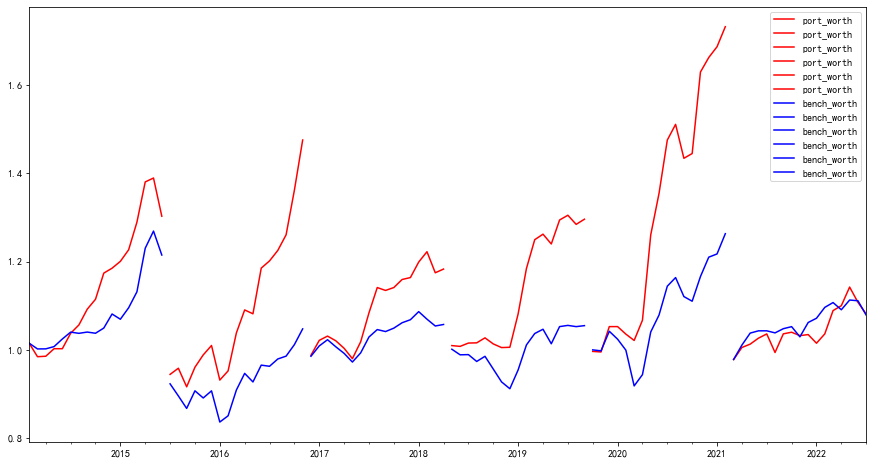

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in port_ws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in bench_ws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [20]:
con_pws = ev.get_continue_worth(port_ws)
con_bws = ev.get_continue_worth(bench_ws)

[]

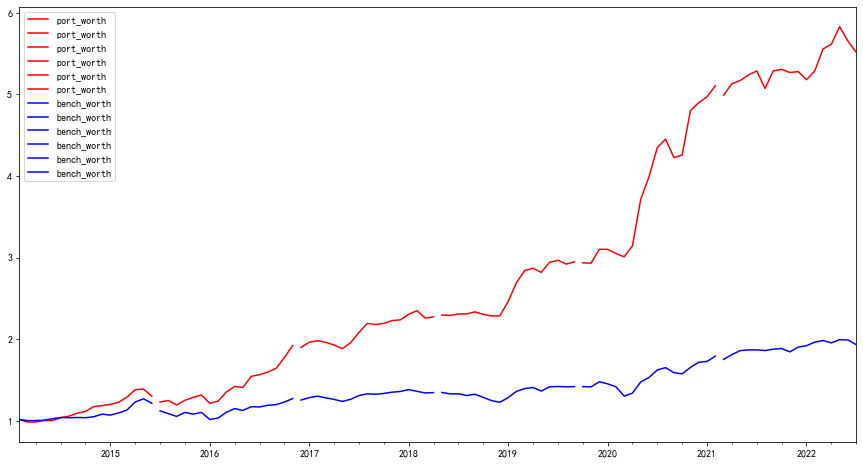

In [21]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in con_pws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in con_bws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()